In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import unicodedata
import re

np.random.seed(1)
tf.random.set_seed(1)

TensorFlow 2.x selected.


In [0]:
corpus = [
'They do not play games.',
'She do not enjoy movies.',
'You do not like politics.',
'We do not eat meat.'
]

## Preprocess text

In [0]:
# https://www.tensorflow.org/tutorials/text/nmt_with_attention

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        )


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer            

In [0]:
def left_space(current, window_size):
    # How much space is there on the left of the current position
    # given the window size ?
    if current >= window_size:
        return window_size
    else:
        return current

def right_space(current, sent_length, window_size):
    # How much space is there on the right of the current position
    # given the window size and the sentence total length?
    if current >= sent_length - window_size:
        return sent_length - current - 1
    else:
        return window_size

def create_dataset(corpus, window_size):
    # Create word mapping to int
    word2Ind = {}
    count = 0
    sentences = []
    for line in corpus:
        sent = preprocess_sentence(line)
        sentences.append(sent)
        for token in sent.split():
            if not token in word2Ind:
                word2Ind[token] = count
                count += 1
    
    # Create traninig set with sliding window
    samples = []
    for sentence in sentences:
        sent = sentence.split()

        for i, w in enumerate(sent):
            # Get ID of center word
            center = word2Ind[w]

            # Compute how many words there are at the left of the center
            left = left_space(i, window_size)

            # Compute how many words there are at the right of the center
            right = right_space(i, len(sent), window_size)

            # Loop over the left-context
            for l in np.arange(1, left+1):
                # Get ID of this word
                idx_ = word2Ind[sent[i-l]]
                # add sample
                samples.append([center, idx_])

            # Do same for the right-context
            for r in np.arange(1, right+1):
                idx_ = word2Ind[sent[i+r]]
                samples.append([center, idx_])
    
    # Reverse the word2Ind dictionary
    ind2Word = {v: k for k, v in word2Ind.items()}

    return word2Ind, samples, ind2Word

In [0]:
# Utility fn to visualize all pairs in the training set
def show_samples(samples, ind2Word):
    for sample in samples:
        print(f'{ind2Word[sample[0]]} ---> {ind2Word[sample[1]]}')

In [0]:
# Build the dataset and the dictionary word->index, index->word

window_size = 1 # 1 on the left and 1 on the right
word2Ind, samples, ind2Word = create_dataset(corpus, window_size)

In [7]:
# look at all pairs in the dataset
show_samples(samples, ind2Word)

<start> ---> they
they ---> <start>
they ---> do
do ---> they
do ---> not
not ---> do
not ---> play
play ---> not
play ---> games
games ---> play
games ---> .
. ---> games
. ---> <end>
<end> ---> .
<start> ---> she
she ---> <start>
she ---> do
do ---> she
do ---> not
not ---> do
not ---> enjoy
enjoy ---> not
enjoy ---> movies
movies ---> enjoy
movies ---> .
. ---> movies
. ---> <end>
<end> ---> .
<start> ---> you
you ---> <start>
you ---> do
do ---> you
do ---> not
not ---> do
not ---> like
like ---> not
like ---> politics
politics ---> like
politics ---> .
. ---> politics
. ---> <end>
<end> ---> .
<start> ---> we
we ---> <start>
we ---> do
do ---> we
do ---> not
not ---> do
not ---> eat
eat ---> not
eat ---> meat
meat ---> eat
meat ---> .
. ---> meat
. ---> <end>
<end> ---> .


## Optimization algorithm

This is a very basic implementation of gradient descent, for the sake of illustration.

The gradient is computed by using tensorflow's GradientTape object.



In [0]:
# Randomly initialize a d-dimensional vector of real numbers
def init_vec(d):
    v = np.random.uniform(size=d)
    v /= v.sum()
    return v

In [0]:
def init_theta(V, d):
    '''
    :param V: size of the vocabulary (num of words)
    :param d: dimensionality of the embeddings

    :return theta: Matrix with all vectors u,v. Even indices (0, 2, 4) are for the u.
    '''
    theta = np.zeros((2*V, d), dtype='float')
    for i in range(2*V):
        theta[i:] = init_vec(d)
    return theta

In [0]:
# Embeddings dimensionality
d = 10
# Num of words in vocabulary
V = len(word2Ind)

# Initial condition for GD
theta = init_theta(V, d)

In [11]:
## Check some data before optimizing
# Will notice that as of now embeddings are just random real numbers.
center = 2
test = 3
print(f'Center is "{ind2Word[center]}", test is "{ind2Word[test]}"')
print(tf.exp(tf.tensordot(theta[center*2+1], theta[test*2], 1)))
for i in range(len(word2Ind)):
    print(f'Test word {i}={ind2Word[i]} >>', tf.exp(tf.tensordot(theta[center*2+1], theta[i*2], 1)))
print('\n')
center = 6
test = 7
print(f'Center is "{ind2Word[center]}", test is "{ind2Word[test]}"')
print(tf.exp(tf.tensordot(theta[center*2+1], theta[test*2], 1)))
for i in range(len(word2Ind)):
    print(f'Test word {i}={ind2Word[i]} >>', tf.exp(tf.tensordot(theta[center*2+1], theta[i*2], 1)))

Center is "do", test is "not"
tf.Tensor(1.116146169619466, shape=(), dtype=float64)
Test word 0=<start> >> tf.Tensor(1.1288971789500877, shape=(), dtype=float64)
Test word 1=they >> tf.Tensor(1.1071297588475966, shape=(), dtype=float64)
Test word 2=do >> tf.Tensor(1.0956330843438067, shape=(), dtype=float64)
Test word 3=not >> tf.Tensor(1.116146169619466, shape=(), dtype=float64)
Test word 4=play >> tf.Tensor(1.0905545227921793, shape=(), dtype=float64)
Test word 5=games >> tf.Tensor(1.1071061567928535, shape=(), dtype=float64)
Test word 6=. >> tf.Tensor(1.0999922273865987, shape=(), dtype=float64)
Test word 7=<end> >> tf.Tensor(1.0823367373518211, shape=(), dtype=float64)
Test word 8=she >> tf.Tensor(1.1132202869717551, shape=(), dtype=float64)
Test word 9=enjoy >> tf.Tensor(1.0931868886201406, shape=(), dtype=float64)
Test word 10=movies >> tf.Tensor(1.1054280115514683, shape=(), dtype=float64)
Test word 11=you >> tf.Tensor(1.1085722458218914, shape=(), dtype=float64)
Test word 12=li

The cost function is

$$
J(\Theta) =
\min_{\Theta(u,v)} -\frac{1}{T} \sum_{i=1}^{T} \sum_{j \in W(i)} \log \frac{\text{exp}(u_j^T v_i)}{\sum_{k \in W} \exp (u_k^T v_i)} =
$$

$$
= \min_{\Theta(u,v)} -\frac{1}{T} \sum_{s \in \mathbf{S}} \log \frac{\text{exp}(u_{s_1}^T v_{s_0})}{\sum_{k \in W} \exp (u_k^T v_{s_0})}, \, \text{where}\, s = [s_0, s_1]
$$

The vectors $u$ and $v$ are the embeddings for each word, in case it's the center word ($u$) or a context word ($v$).

In [0]:
def compute_numerator(i, j, theta):
    '''
    Compute numerator of the final term of the objetive function.

    :param i: Is the row-index, in Theta, of the center word.
    :param j: Is the row-index, in Theta, of the context word.
    :param theta: Algorithm parameters.
    '''
    # Theta stacks all u and v vectors.
    # [u_0; v_0; u_1; v_1; ...; u_2*i; v2*i]
    # Hence u_j is at row 2*j
    # v_i is at row 2*i + 1
    return tf.exp(tf.tensordot(theta[2*j], theta[2*i + 1], 1))


def compute_denominator(i, theta):
    '''
    Compute the denominator of the sofmax when the center word is i.
    '''
    # Must use TF objects to differentiate.
    tot = tf.convert_to_tensor(0., dtype='float64')

    # Loop through all u's vectors
    # Hence through Theta with step 2, starting from zero.
    for w in np.arange(0, theta.shape[0], 2):
        tot += tf.exp(tf.tensordot(theta[w], theta[2*i + 1], 1))
    return tot


def loss_element(i, j, theta):
    '''
    Compute one element of the total sum that makes the objective function.
    That means, for a single sample s = [i, j]

    :param i: First item of the current sample. Also, word2Ind of the first word in the sample (center word).
    :param j: Second item of the current sample. Also, word2Ind of the second word in the sample.
    '''
    denom = compute_denominator(i, theta)
    numer = compute_numerator(i, j, theta)
    return tf.math.log(numer / denom)


def loss_total(theta, samples):
    '''
    Compute the overall loss for the current value of the parameters.

    :param theta: The algorithm parameters.
    :param samples: List of lists with the shifting windows for training.
    '''
    loss = tf.convert_to_tensor(0., dtype='float64')
    with tf.GradientTape() as gt:
        gt.watch(theta)
        for sample in samples:
            i = sample[0] # this is always the center word
            j = sample[1]
            loss -= loss_element(i, j, theta)
        loss /= len(samples)  # 1/T
    dTheta = gt.gradient(loss, theta)
    return loss, dTheta

In [0]:
def grad_desc(x0, samples, fn, lr, iterations=200):
    '''
    Very basic implementation of gradient descent.

    :param x0: Initial condition (Theta).
    :param samples: List of training samples.
    :param fn: Function to compute current loss and gradient.
    :param lr: Learning rate (constant).
    :param iter: Number of iterations.
    '''

    losses = np.zeros((iterations,), dtype='float32')

    var = tf.convert_to_tensor(x0)
    for n in range(iterations):
        loss, dTheta = fn(var, samples)
        losses[n] = loss
        print(f'Epoch {n}, loss {loss.numpy()}')
        var = var - (lr * dTheta / np.linalg.norm(dTheta))

    return var, losses

In [14]:
theta_opt, losses = grad_desc(theta, samples, loss_total, 0.2, iterations=100)

Epoch 0, loss 2.832354799216204
Epoch 1, loss 2.817975410019655
Epoch 2, loss 2.8029208497187943
Epoch 3, loss 2.786414700888424
Epoch 4, loss 2.7679671112308144
Epoch 5, loss 2.7473155253354578
Epoch 6, loss 2.7243384030577684
Epoch 7, loss 2.6989992283639235
Epoch 8, loss 2.671317734478463
Epoch 9, loss 2.641356607931803
Epoch 10, loss 2.609216221217832
Epoch 11, loss 2.5750335506454216
Epoch 12, loss 2.538983239470636
Epoch 13, loss 2.501279473277997
Epoch 14, loss 2.4621774552187063
Epoch 15, loss 2.4219730904885717
Epoch 16, loss 2.380999249864169
Epoch 17, loss 2.3396169882819153
Epoch 18, loss 2.298200728331357
Epoch 19, loss 2.2571179490671396
Epoch 20, loss 2.2167061279253804
Epoch 21, loss 2.1772515783739688
Epoch 22, loss 2.138974953584641
Epoch 23, loss 2.102025657067379
Epoch 24, loss 2.0664830418281066
Epoch 25, loss 2.0323590235041022
Epoch 26, loss 1.9995983436359432
Epoch 27, loss 1.9680799395688628
Epoch 28, loss 1.9376292450289994
Epoch 29, loss 1.9080468569815632
Ep

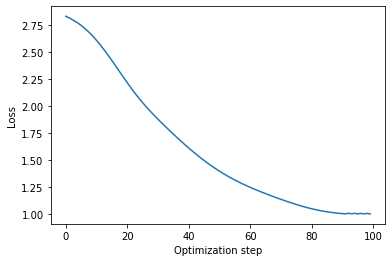

In [16]:
# Look at the whole loss function during the optimization
intv = np.arange(0, len(losses))
_ = plt.plot(intv, losses[intv])
_ = plt.xlabel('Optimization step')
_ = plt.ylabel('Loss')

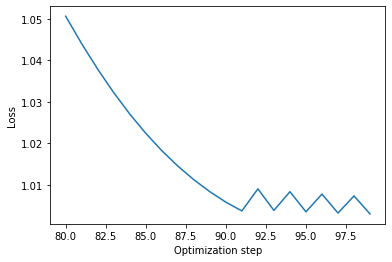

In [17]:
# Zoom in the loss during the final optimization steps
intv = np.arange(80, len(losses))
_ = plt.plot(intv, losses[intv])
_ = plt.xlabel('Optimization step')
_ = plt.ylabel('Loss')

The oscillations are a sign that we've got to stop the iterative procedure. It would possible to improve it by changing some hyperparameter (such as the learning rate).

## Show some samples

In [18]:
## Check some data after optimizing
# Will notice that the dot product is now much higher for the context words than for the others, for each given center word
center = 2
test = 3
print(f'Center is "{ind2Word[center]}", test is "{ind2Word[test]}"')
print(tf.exp(tf.tensordot(theta_opt[center*2+1], theta_opt[test*2], 1)))
for i in range(len(word2Ind)):
    print(f'Test word {i}={ind2Word[i]} >>', tf.exp(tf.tensordot(theta_opt[center*2+1], theta_opt[i*2], 1)))
print('\n')
center = 6
test = 7
print(f'Center is "{ind2Word[center]}", test is "{ind2Word[test]}"')
print(tf.exp(tf.tensordot(theta_opt[center*2+1], theta_opt[test*2], 1)))
for i in range(len(word2Ind)):
    print(f'Test word {i}={ind2Word[i]} >>', tf.exp(tf.tensordot(theta_opt[center*2+1], theta_opt[i*2], 1)))

Center is "do", test is "not"
tf.Tensor(265.47320718665674, shape=(), dtype=float64)
Test word 0=<start> >> tf.Tensor(0.31829067616650725, shape=(), dtype=float64)
Test word 1=they >> tf.Tensor(96.39118135113179, shape=(), dtype=float64)
Test word 2=do >> tf.Tensor(0.07839746275724133, shape=(), dtype=float64)
Test word 3=not >> tf.Tensor(265.47320718665674, shape=(), dtype=float64)
Test word 4=play >> tf.Tensor(0.18064613586322822, shape=(), dtype=float64)
Test word 5=games >> tf.Tensor(0.3686308526571574, shape=(), dtype=float64)
Test word 6=. >> tf.Tensor(0.07539733403450666, shape=(), dtype=float64)
Test word 7=<end> >> tf.Tensor(0.018871837503493753, shape=(), dtype=float64)
Test word 8=she >> tf.Tensor(96.34016252586977, shape=(), dtype=float64)
Test word 9=enjoy >> tf.Tensor(0.019857738915322647, shape=(), dtype=float64)
Test word 10=movies >> tf.Tensor(0.3100757746416495, shape=(), dtype=float64)
Test word 11=you >> tf.Tensor(96.50989558451292, shape=(), dtype=float64)
Test wor